## **4. Methodology**

### **4.1 Overview of Experimental Procedure**

This study conducts a comparative evaluation of three fine-tuned versions of the DeiT-Small Vision Transformer (ViT) architecture on a custom image classification task. The complete process involves dataset preparation, model setup, training with carefully controlled variations, and performance evaluation using consistent metrics across versions.

---

### **4.2 Dataset Preparation**

A custom image dataset consisting of 700 original images across 7 distinct classes was augmented to a total of approximately 4900 images. Each image filename was prefixed with a base identifier to retain a link between original images and their augmented variants.

To ensure a fair evaluation and avoid data leakage, group-wise splitting was applied. Images sharing a common base identifier were grouped together, and these groups were then randomly divided into three disjoint subsets:
- **Training Set**: 70%
- **Validation Set**: 15%
- **Test Set**: 15%

This ensured that no augmented image derived from a particular original image appeared in multiple splits. Transformations applied during data loading included resizing to 224×224 pixels and normalization with ImageNet statistics to meet DeiT-Small input requirements.

---

### **4.3 Model Architecture and Training Configurations**

Three versions of the DeiT-Small (`deit_small_patch16_224`) model were fine-tuned using different strategies. All models were built using the `timm` library and trained using PyTorch.

#### **4.3.1 Version 1 (V1)**
- **Pretrained Weights**: Yes (ImageNet)
- **Frozen Layers**: Patch embedding + first four transformer blocks
- **Classifier Head**: Standard linear head replaced with custom head (512 units + ReLU + Linear)
- **Optimizer**: AdamW with a learning rate of 1e-4
- **Scheduler**: StepLR (gamma=0.1 every 5 epochs)
- **Early Stopping**: Patience of 3 epochs
- **Dropout**: Not used in this version

#### **4.3.2 Version 2 (V2)**
- **Pretrained Weights**: Custom weights from V1 (excluding classifier head)
- **Frozen Layers**: Patch embedding + first three transformer blocks
- **Classifier Head**: Sequential head (512 units + ReLU + Dropout 0.5 + LayerNorm + Linear)
- **Optimizer**: AdamW with layer-wise learning rates
- **Scheduler**: CosineAnnealingLR
- **Early Stopping**: Patience of 6 epochs

#### **4.3.3 Version 3 (V3)**
- **Pretrained Weights**: Custom weights from V2 (excluding classifier head)
- **Frozen Layers**: Initially patch embedding + first three transformer blocks
- **Classifier Head**: Same structure as V2, with dropout adjusted to 0.5
- **Training Strategy**: Gradual unfreezing of transformer blocks at epochs 4, 7, and 10
- **Optimizer**: AdamW with layer-wise learning rates
- **Scheduler**: ReduceLROnPlateau (based on validation loss)
- **Early Stopping**: Patience of 6 epochs
- **Additional Monitoring**: Gradient statistics collected for trainable layers

---

### **4.4 Evaluation Protocol**

All models were evaluated using the same test split to ensure fair comparison. Evaluation metrics included:
- **Accuracy**
- **Precision, Recall, F1-score (per class and averaged)**
- **Specificity**
- **Matthews Correlation Coefficient (MCC)**
- **Cohen’s Kappa**
- **Top-k Accuracy (k = 1, 3, 5)**
- **ROC AUC and Precision-Recall Curves**
- **Gradient Magnitude Analysis (V3 only)**

Evaluation outputs were saved in structured directories for each version. Confusion matrices, ROC curves, and precision-recall curves were visualized for interpretability. In addition, training histories (loss and accuracy curves) were plotted and analyzed for convergence behavior and overfitting trends.

---

### **4.5 Model Saving and Artifact Organization**

Each version of the model was saved along with its training history, evaluation metrics, and diagnostic visualizations. Artifacts were organized into version-specific directories (`V1_Results`, `V2_Results`, `V3_Results`). Final test evaluations were saved separately under `Test_Eval` subdirectories.

# Import necessary libraries

In [1]:
# Required libraries are imported.
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

/Users/tahfimibnkhan/deep_learning_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import sys
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_model_artifacts

In [5]:
# The dataset path is defined.
dataset_path = "/Users/tahfimibnkhan/Desktop/ViT/DATASET/AUGMENTED_DATASET"

# Transformations are applied to the images.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

In [6]:
# The dataset is loaded using ImageFolder.
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# The number of classes in the dataset is obtained.
num_classes = len(dataset.classes)
print(f"Number of classes: {num_classes}")

Number of classes: 7


In [7]:
import os
import random
from torchvision import datasets
from torch.utils.data import DataLoader, Subset

# Groups of images were prepared using base image identifiers
image_groups = {}
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])  # Base ID was extracted before augmentation tags
    if original_id not in image_groups:
        image_groups[original_id] = []
    image_groups[original_id].append(img_path)

# Group keys were shuffled to ensure random distribution
random.seed(42)
group_keys = list(image_groups.keys())
random.shuffle(group_keys)

# The dataset was split into training (70%), validation (15%), and test (15%) sets
total = len(group_keys)
train_size = round(0.70 * total)
val_size = round(0.15 * total)
test_size = total - train_size - val_size

train_keys = set(group_keys[:train_size])
val_keys = set(group_keys[train_size:train_size + val_size])
test_keys = set(group_keys[train_size + val_size:])

# Indices were assigned to the appropriate split based on the group identifier
train_indices, val_indices, test_indices = [], [], []

for idx, (img_path, _) in enumerate(dataset.samples):
    filename = os.path.basename(img_path)
    original_id = "_".join(filename.split("_")[:-1])
    if original_id in train_keys:
        train_indices.append(idx)
    elif original_id in val_keys:
        val_indices.append(idx)
    elif original_id in test_keys:
        test_indices.append(idx)

# Subsets were created for each split
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)
test_data = Subset(dataset, test_indices)

# Data loaders were initialized for model1training and evaluation
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

Training samples: 3462
Validation samples: 709
Test samples: 729


In [8]:
num_classes = 7  # The number of target classes is specified for classification.

# The DeiT-Small model1is loaded with pre-trained weights, and the classification head is adjusted.
model1 = timm.create_model('deit_small_patch16_224', pretrained=True, num_classes=num_classes)

# The patch embedding layer is frozen to retain pre-trained features.
for param in model1.patch_embed.parameters():
    param.requires_grad = False  

# The first four transformer blocks are frozen to preserve learned representations.
for i in range(4):  
    for param in model1.blocks[i].parameters():
        param.requires_grad = False  

# The model1is transferred to GPU if available; otherwise, it remains on CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)

print(f"Model1 loaded, early layers frozen, and moved to {device}")

Model1 loaded, early layers frozen, and moved to cpu


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# The loss function is defined using CrossEntropyLoss for multi-class classification.
criterion = nn.CrossEntropyLoss()

# The optimizer is defined using AdamW, which is preferred over Adam due to better weight decay handling.
optimizer = optim.AdamW(model1.parameters(), lr=1e-4, weight_decay=1e-5)

# A step-based learning rate scheduler is used, reducing the learning rate by a factor of 0.1 every 5 epochs.
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("Loss function, optimizer, and learning rate scheduler have been defined.")

Loss function, optimizer, and learning rate scheduler have been defined.


In [22]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15):
    history1 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    # Early stopping initialization
    best_val_loss = float('inf')
    patience = 3
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history1["train_loss"].append(train_loss)
        history1["train_acc"].append(train_acc)

        # Validation Phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100. * val_correct / val_total
        history1["val_loss"].append(val_loss)
        history1["val_acc"].append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f"\nEarly stopping triggered at epoch {epoch+1}!")
                break

        # Adjust learning rate
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return history1
# Training and getting history
history1= train(model1, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15)

Epoch 1/15: 100%|█████████████████████████████| 109/109 [05:24<00:00,  2.98s/it]


Epoch 1/15: Train Loss: 0.6073, Train Acc: 77.99% | Val Loss: 0.2715, Val Acc: 90.69%


Epoch 2/15: 100%|█████████████████████████████| 109/109 [05:12<00:00,  2.87s/it]


Epoch 2/15: Train Loss: 0.1453, Train Acc: 95.00% | Val Loss: 0.1966, Val Acc: 93.51%


Epoch 3/15: 100%|█████████████████████████████| 109/109 [05:26<00:00,  2.99s/it]


Epoch 3/15: Train Loss: 0.0533, Train Acc: 98.30% | Val Loss: 0.3133, Val Acc: 89.70%


Epoch 4/15: 100%|█████████████████████████████| 109/109 [05:28<00:00,  3.02s/it]


Epoch 4/15: Train Loss: 0.0475, Train Acc: 98.47% | Val Loss: 0.1754, Val Acc: 94.36%


Epoch 5/15: 100%|█████████████████████████████| 109/109 [05:42<00:00,  3.15s/it]


Epoch 5/15: Train Loss: 0.0232, Train Acc: 99.34% | Val Loss: 0.1838, Val Acc: 94.08%


Epoch 6/15: 100%|█████████████████████████████| 109/109 [05:51<00:00,  3.22s/it]


Epoch 6/15: Train Loss: 0.0035, Train Acc: 100.00% | Val Loss: 0.1258, Val Acc: 95.91%


Epoch 7/15: 100%|█████████████████████████████| 109/109 [06:28<00:00,  3.56s/it]


Epoch 7/15: Train Loss: 0.0023, Train Acc: 100.00% | Val Loss: 0.1222, Val Acc: 95.91%


Epoch 8/15: 100%|█████████████████████████████| 109/109 [07:03<00:00,  3.88s/it]


Epoch 8/15: Train Loss: 0.0021, Train Acc: 100.00% | Val Loss: 0.1208, Val Acc: 96.05%


Epoch 9/15: 100%|█████████████████████████████| 109/109 [07:44<00:00,  4.26s/it]


Epoch 9/15: Train Loss: 0.0019, Train Acc: 100.00% | Val Loss: 0.1197, Val Acc: 96.05%


Epoch 10/15: 100%|████████████████████████████| 109/109 [07:25<00:00,  4.08s/it]


Epoch 10/15: Train Loss: 0.0018, Train Acc: 100.00% | Val Loss: 0.1187, Val Acc: 96.19%


Epoch 11/15: 100%|████████████████████████████| 109/109 [05:52<00:00,  3.23s/it]


Epoch 11/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1186, Val Acc: 96.19%


Epoch 12/15: 100%|████████████████████████████| 109/109 [05:26<00:00,  2.99s/it]


Epoch 12/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1186, Val Acc: 96.19%


Epoch 13/15: 100%|████████████████████████████| 109/109 [05:20<00:00,  2.94s/it]


Epoch 13/15: Train Loss: 0.0017, Train Acc: 100.00% | Val Loss: 0.1185, Val Acc: 96.19%


Epoch 14/15: 100%|████████████████████████████| 109/109 [05:32<00:00,  3.05s/it]


Epoch 14/15: Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.1184, Val Acc: 96.19%


Epoch 15/15: 100%|████████████████████████████| 109/109 [05:46<00:00,  3.17s/it]


Epoch 15/15: Train Loss: 0.0016, Train Acc: 100.00% | Val Loss: 0.1184, Val Acc: 96.19%


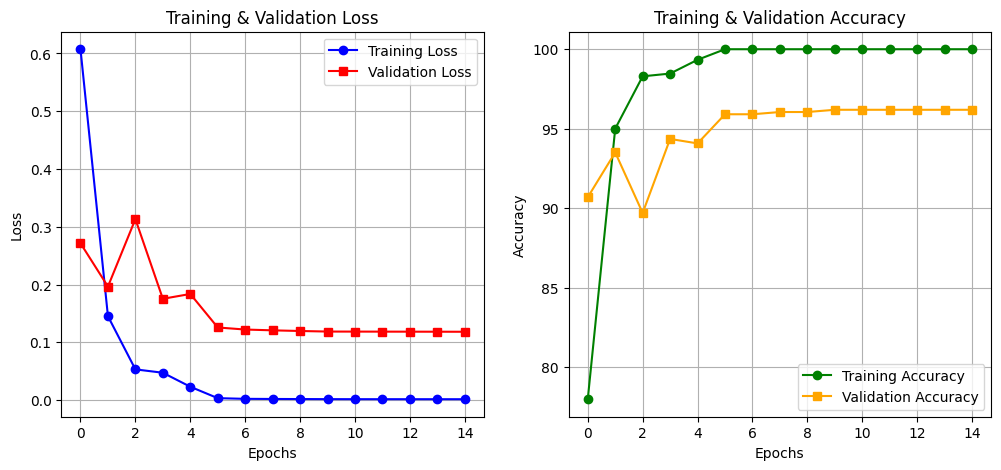

In [77]:
plottting1=plotting(history1)

# Computeing Performance Metrics


Evaluating model with Validation loader...

Overall Accuracy: 96.19%
Overall Error Rate: 3.81%
F1-Score (Macro-Averaged): 96.17%
F1-Score (Weighted): 96.19%
Matthews Correlation Coefficient (MCC): 95.56%
Cohen’s Kappa Score: 95.55%
Top-1 Accuracy (%): 96.19%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.030922 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          93.81       95.50         94.64            98.83
 BRRI_28          98.80       91.11         94.80            99.84
 BRRI_29          92.92       94.59         93.75            98.66
 BRRI_34          97.22       98.13         97.67            99.50
 BRRI_50          94.12       97.56         95.81            99.20
 BRRI_74          99.07      100.00         99.53            99.83
    BR_5          97.98       96.04         97.00            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 B

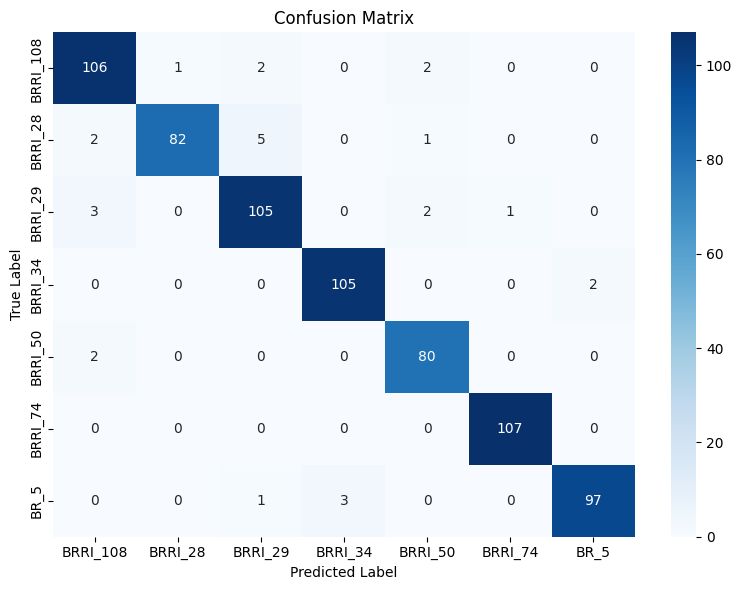

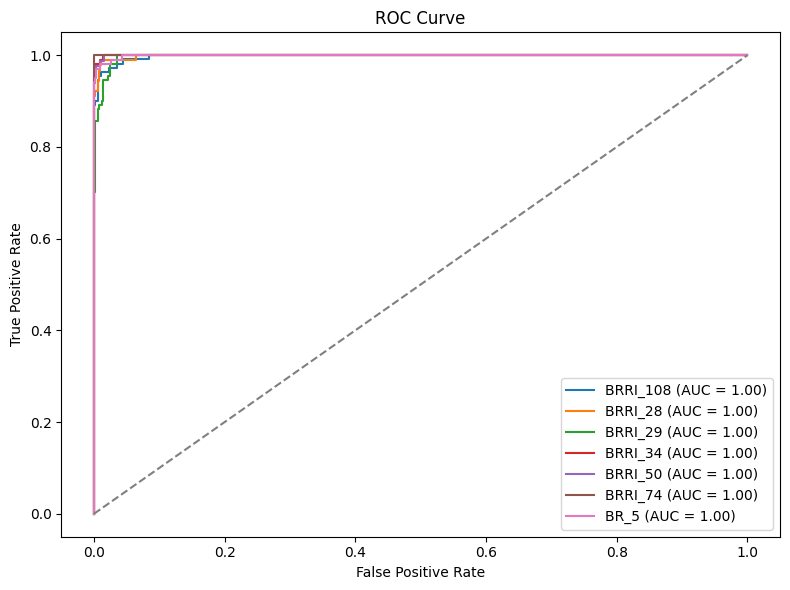

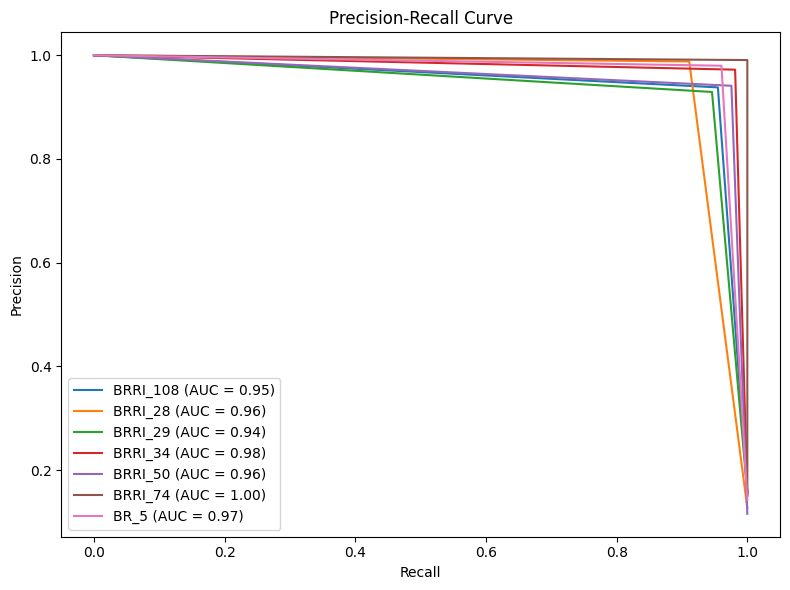

In [85]:
metrics1=evaluate_model(model1, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader...

Overall Accuracy: 96.02%
Overall Error Rate: 3.98%
F1-Score (Macro-Averaged): 96.07%
F1-Score (Weighted): 96.02%
Matthews Correlation Coefficient (MCC): 95.36%
Cohen’s Kappa Score: 95.35%
Top-1 Accuracy (%): 96.02%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.033560 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          94.64       90.60         92.58            99.02
 BRRI_28          96.61       95.00         95.80            99.34
 BRRI_29          90.72       95.65         93.12            98.59
 BRRI_34          95.61      100.00         97.76            99.19
 BRRI_50          97.25       98.15         97.70            99.52
 BRRI_74          97.83       98.90         98.36            99.69
    BR_5         100.00       94.57         97.21           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI

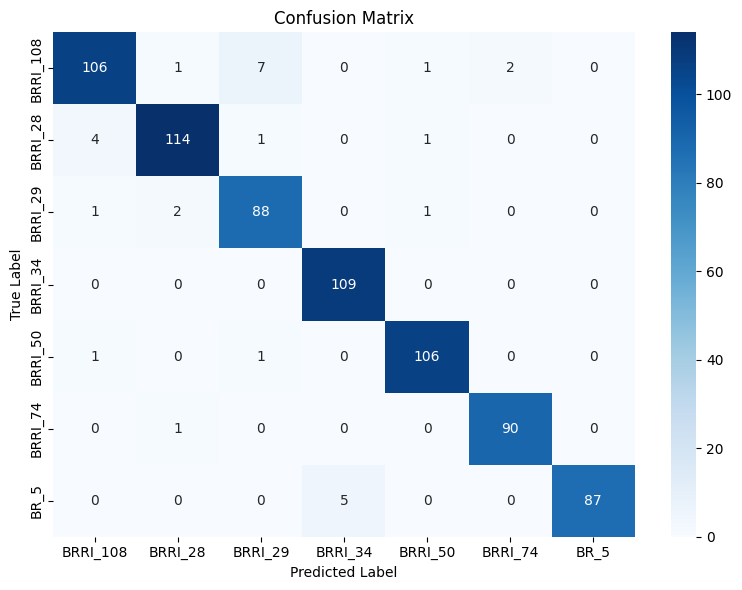

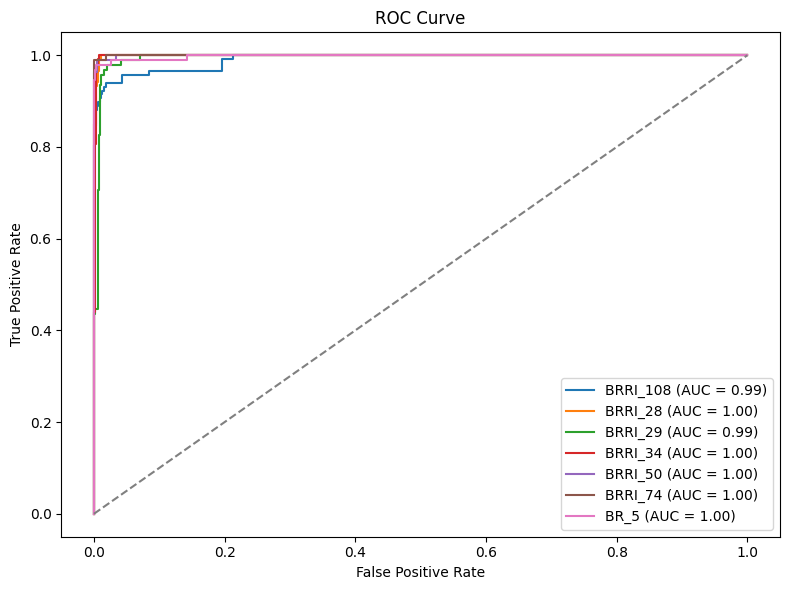

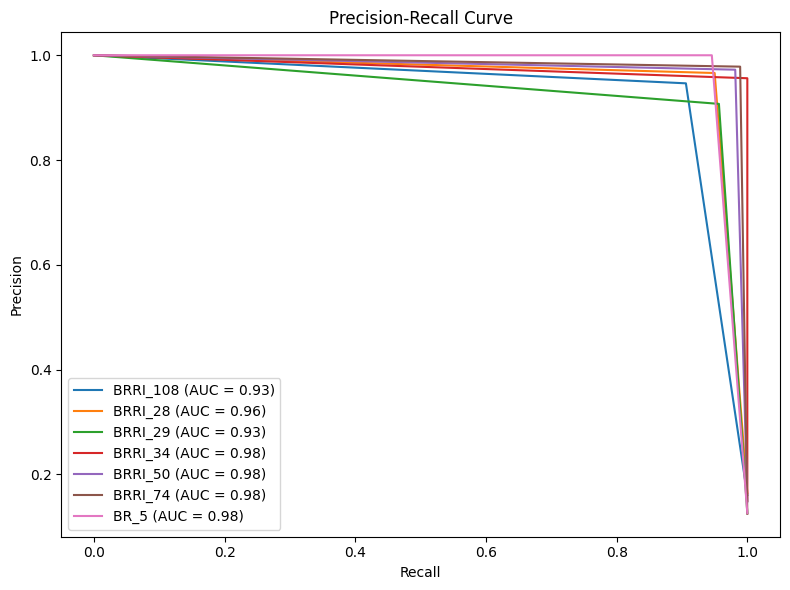

In [86]:
metrics1=evaluate_model(model1, test_loader, class_names=dataset.classes, loader_name="Testing")

In [87]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")

    class_metrics = metrics.get("Class-Wise Metrics") or metrics.get("class_metrics")
    if class_metrics:
        class_metrics_df = pd.DataFrame(class_metrics)
        class_metrics_path = os.path.join(eval_dir, f"deit_class_wise_metrics_{version}.csv")
        class_metrics_df.to_csv(class_metrics_path, index=False)
        print(f"Class-wise metrics saved at: {class_metrics_path}")
    else:
        print("No class-wise metrics found in evaluation results.")
        
save_deit_artifacts(model1, history1, metrics1, version="1")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_1.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_1.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_1.json
Class-wise metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_class_wise_metrics_1.csv


# Version 2

In [12]:
import timm
import torch
import torch.nn as nn
import sys
# the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from Utils.utils import evaluate_model, plotting, save_model_artifacts

# The device is automatically selected based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# The DeiT-Small architecture is initialized without pretrained weights
model21 = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=num_classes)

# Custom pretrained weights are loaded from the specified path
model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_1.pth"
model21.load_state_dict(torch.load(model_path, map_location=device))

# The classification head is replaced with a custom sequential module
in_features = model21.head.in_features
model21.head = nn.Sequential(
    nn.Linear(in_features, 512),  # An intermediate linear layer is added
    nn.ReLU(),  # Non-linearity is introduced
    nn.Dropout(p=0.5),  # Regularization is applied through dropout
    nn.LayerNorm(512),  # Normalization is included for stability
    nn.Linear(512, num_classes)  # Final classification is performed
)

# The patch embedding layer is kept frozen
for param in model21.patch_embed.parameters():  
    param.requires_grad = False  

# The first three transformer blocks are maintained in frozen state
for i in range(3):
    for param in model21.blocks[i].parameters():
        param.requires_grad = False

# The model is transferred to the available computing device
model21.to(device)

# Model configuration is confirmed through console output
print(f"Model21 is prepared for fine-tuning with {sum(p.requires_grad for p in model21.parameters())} trainable parameters on {device}")



import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Defined loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rate decay (recommended for ViTs)
optimizer = optim.AdamW([
    {'params': model21.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model21.blocks.parameters(), 'lr': 3e-5},
    {'params': model21.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Learning rate scheduler (chose Cosine Annealing for smooth decay)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)  

print("Loss function, optimizer, and learning rate scheduler have been defined.")


def train_model2(model2, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience):
    """
    The model is trained with early stopping and learning rate scheduling.
    Training progress and metrics are tracked and returned.
    """
    # Training history is initialized for metric tracking
    history2 = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    # Early stopping parameters are configured
    best_val_loss = float("inf")
    early_stop_counter = 0  

    for epoch in range(epochs):
        # The model is set to training mode
        model2.train()
        running_loss, correct_predictions, total_samples = 0.0, 0, 0

        # Training batches are processed
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            # Forward and backward passes are executed
            optimizer.zero_grad()
            outputs = model2(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Metrics are accumulated
            running_loss += loss.item()
            predicted_labels = torch.argmax(outputs, dim=1)
            total_samples += labels.size(0)
            correct_predictions += (predicted_labels == labels).sum().item()

        # Training metrics are calculated and stored
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_predictions / total_samples
        history2["train_loss"].append(epoch_train_loss)
        history2["train_acc"].append(epoch_train_acc)

        # Validation phase is initiated
        model2.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        
        # Validation batches are processed without gradient computation
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model2(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Validation metrics are calculated and stored
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * val_correct / val_total
        history2["val_loss"].append(epoch_val_loss)
        history2["val_acc"].append(epoch_val_acc)

        # Progress is reported
        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

        # Model improvement is checked
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            early_stop_counter = 0
            torch.save(model2.state_dict(), "deit_smallV2_best.pth")
            print("Validation loss improved - model weights saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement counter: {early_stop_counter}/{patience}")
            if early_stop_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

        # Learning rate is adjusted according to scheduler type
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)
        else:
            scheduler.step()

    return history2

# The model is trained with configured parameters
history3 = train_model2(
    model2=model21,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=15,
    patience=15
)

Model21 is prepared for fine-tuning with 118 trainable parameters on cpu
Loss function, optimizer, and learning rate scheduler have been defined.


Epoch 1/15: 100%|█████████████████████████████| 109/109 [04:57<00:00,  2.73s/it]


Epoch 1/15: Train Loss: 0.2683 | Val Loss: 0.1176 | Train Acc: 95.12% | Val Acc: 96.05%
Validation loss improved - model weights saved.


Epoch 2/15: 100%|█████████████████████████████| 109/109 [05:08<00:00,  2.83s/it]


Epoch 2/15: Train Loss: 0.0249 | Val Loss: 0.1034 | Train Acc: 100.00% | Val Acc: 97.32%
Validation loss improved - model weights saved.


Epoch 3/15: 100%|█████████████████████████████| 109/109 [05:14<00:00,  2.89s/it]


Epoch 3/15: Train Loss: 0.0138 | Val Loss: 0.1070 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 1/15


Epoch 4/15: 100%|█████████████████████████████| 109/109 [05:35<00:00,  3.08s/it]


Epoch 4/15: Train Loss: 0.0096 | Val Loss: 0.1132 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 2/15


Epoch 5/15: 100%|█████████████████████████████| 109/109 [05:27<00:00,  3.01s/it]


Epoch 5/15: Train Loss: 0.0075 | Val Loss: 0.1178 | Train Acc: 100.00% | Val Acc: 97.32%
No improvement counter: 3/15


Epoch 6/15: 100%|█████████████████████████████| 109/109 [05:41<00:00,  3.13s/it]


Epoch 6/15: Train Loss: 0.0062 | Val Loss: 0.1196 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 4/15


Epoch 7/15: 100%|█████████████████████████████| 109/109 [06:02<00:00,  3.33s/it]


Epoch 7/15: Train Loss: 0.0055 | Val Loss: 0.1311 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 5/15


Epoch 8/15: 100%|█████████████████████████████| 109/109 [06:31<00:00,  3.59s/it]


Epoch 8/15: Train Loss: 0.0048 | Val Loss: 0.1269 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 6/15


Epoch 9/15: 100%|█████████████████████████████| 109/109 [06:45<00:00,  3.72s/it]


Epoch 9/15: Train Loss: 0.0044 | Val Loss: 0.1323 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 7/15


Epoch 10/15: 100%|████████████████████████████| 109/109 [06:44<00:00,  3.71s/it]


Epoch 10/15: Train Loss: 0.0041 | Val Loss: 0.1318 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 8/15


Epoch 11/15: 100%|████████████████████████████| 109/109 [06:56<00:00,  3.82s/it]


Epoch 11/15: Train Loss: 0.0038 | Val Loss: 0.1352 | Train Acc: 100.00% | Val Acc: 97.18%
No improvement counter: 9/15


Epoch 12/15: 100%|████████████████████████████| 109/109 [05:49<00:00,  3.20s/it]


Epoch 12/15: Train Loss: 0.0037 | Val Loss: 0.1347 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 10/15


Epoch 13/15: 100%|████████████████████████████| 109/109 [05:50<00:00,  3.22s/it]


Epoch 13/15: Train Loss: 0.0036 | Val Loss: 0.1353 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 11/15


Epoch 14/15: 100%|████████████████████████████| 109/109 [05:20<00:00,  2.94s/it]


Epoch 14/15: Train Loss: 0.0035 | Val Loss: 0.1356 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 12/15


Epoch 15/15: 100%|████████████████████████████| 109/109 [05:10<00:00,  2.85s/it]


Epoch 15/15: Train Loss: 0.0036 | Val Loss: 0.1357 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement counter: 13/15


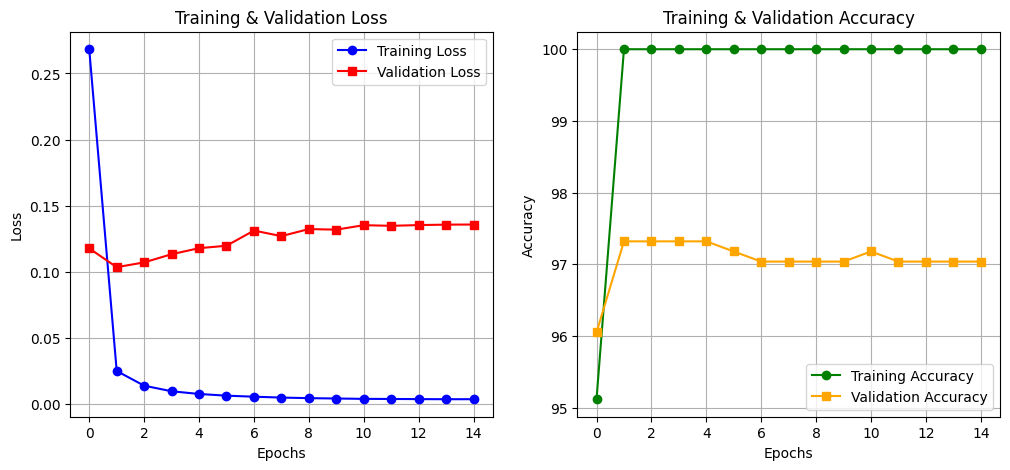

In [13]:
plotting21=plotting(history3)


Evaluating model with Validation loader.

Overall Accuracy: 97.04%
Overall Error Rate: 2.96%
F1-Score (Macro-Averaged): 97.05%
F1-Score (Weighted): 97.04%
Matthews Correlation Coefficient (MCC): 96.54%
Cohen’s Kappa Score: 96.54%
Top-1 Accuracy (%): 97.04%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.025134 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          94.74       97.30         96.00            99.00
 BRRI_28          98.85       95.56         97.18            99.84
 BRRI_29          94.55       93.69         94.12            99.00
 BRRI_34          98.13       98.13         98.13            99.67
 BRRI_50          95.24       97.56         96.39            99.36
 BRRI_74         100.00      100.00        100.00           100.00
    BR_5          98.00       97.03         97.51            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRR

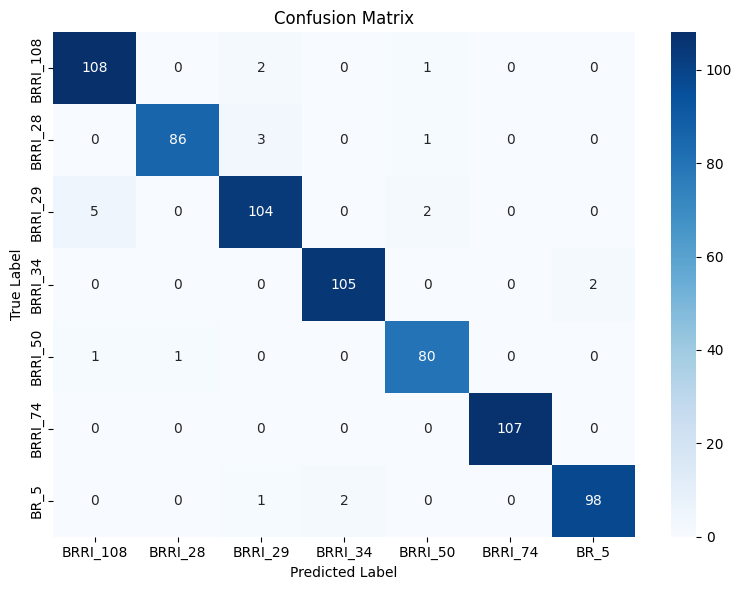

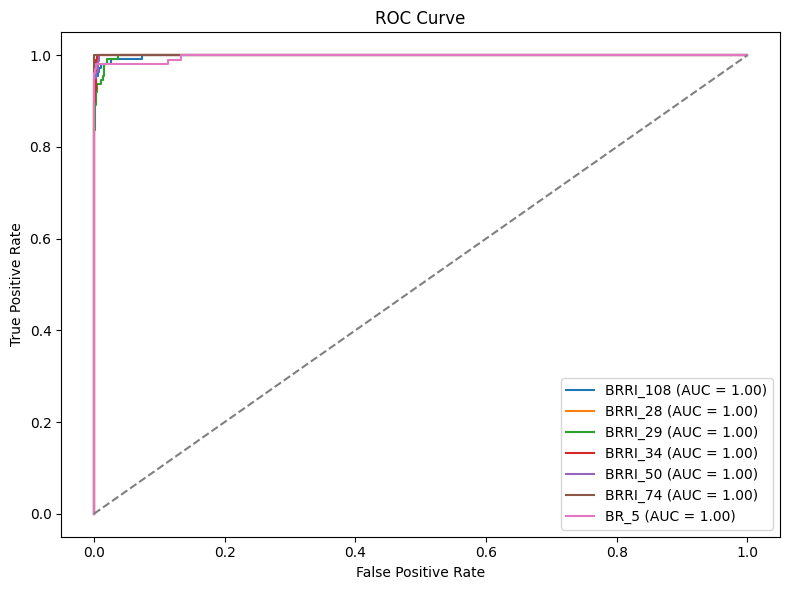

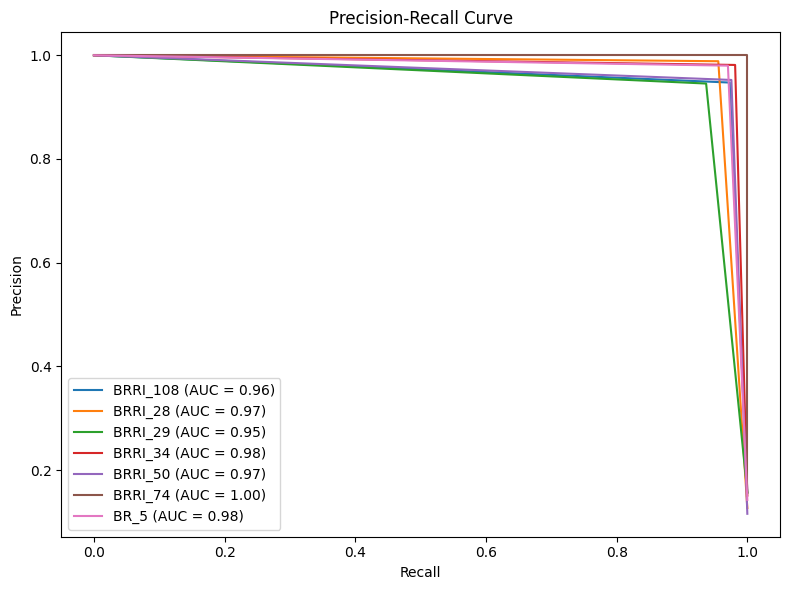

In [14]:
metrics3=evaluate_model(model21, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader.

Overall Accuracy: 97.39%
Overall Error Rate: 2.61%
F1-Score (Macro-Averaged): 97.41%
F1-Score (Weighted): 97.40%
Matthews Correlation Coefficient (MCC): 96.97%
Cohen’s Kappa Score: 96.95%
Top-1 Accuracy (%): 97.39%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.025923 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          99.08       92.31         95.58            99.84
 BRRI_28          96.72       98.33         97.52            99.34
 BRRI_29          90.10       98.91         94.30            98.43
 BRRI_34          97.32      100.00         98.64            99.52
 BRRI_50         100.00       97.22         98.59           100.00
 BRRI_74          98.90       98.90         98.90            99.84
    BR_5         100.00       96.74         98.34           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

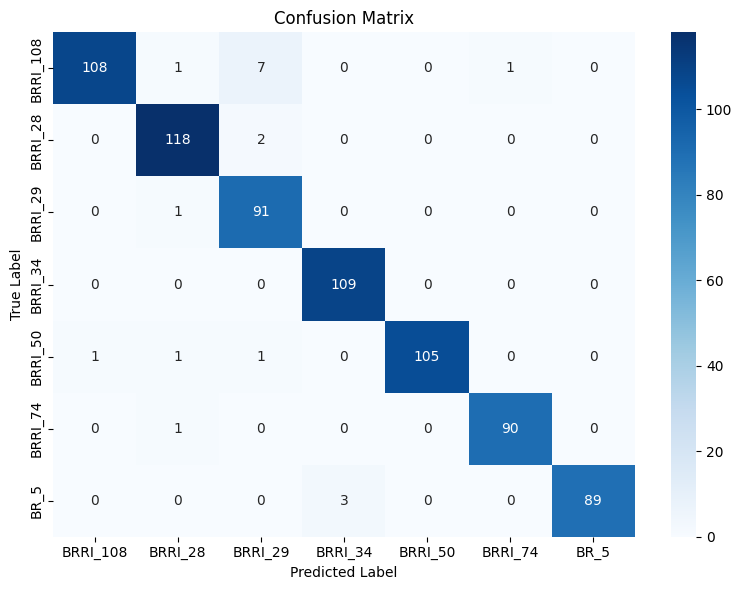

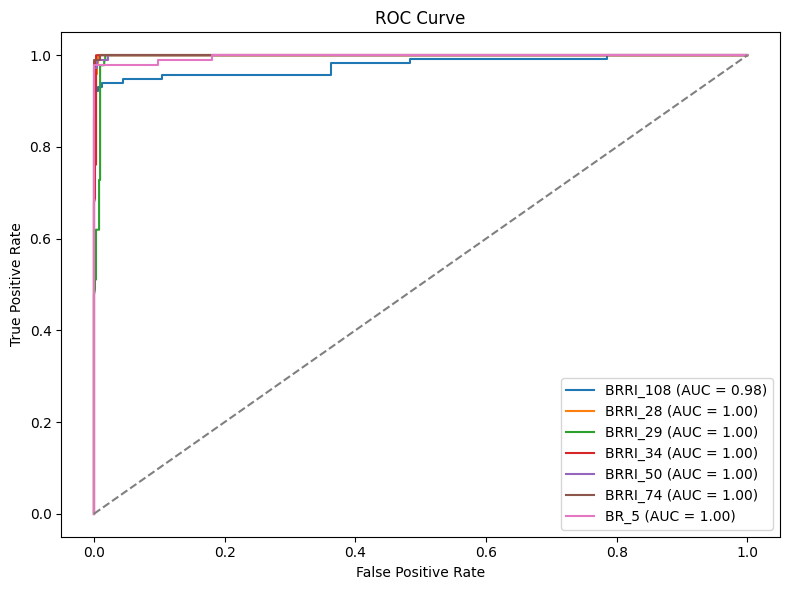

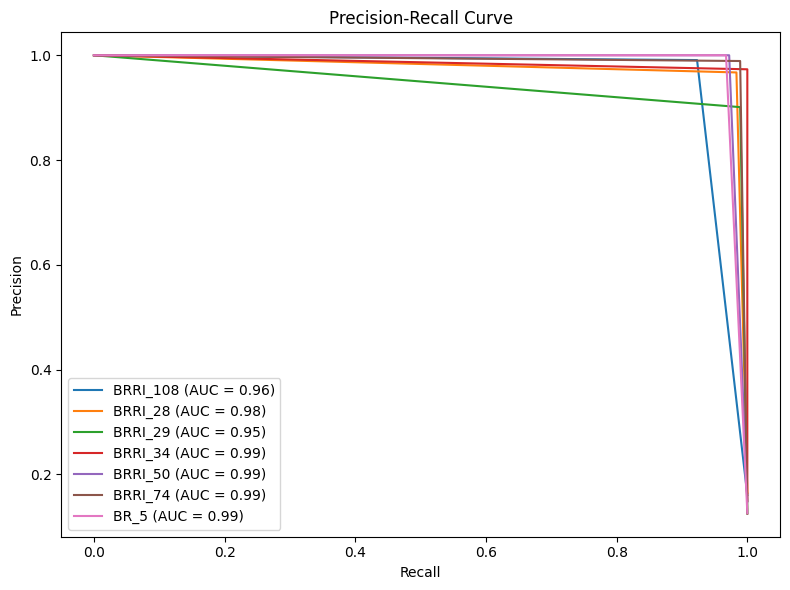

In [15]:
metrics3=evaluate_model(model21, test_loader, class_names=dataset.classes, loader_name="Testing")

In [20]:
def save_deit_artifacts(model, history, metrics, version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    logs_dir = os.path.join(base_dir, "RESULTS", "logs")
    os.makedirs(logs_dir, exist_ok=True)

    training_metrics = {
        "train_loss": history["train_loss"][-1],
        "train_acc": history["train_acc"][-1],
        "val_loss": history["val_loss"][-1],
        "val_acc": history["val_acc"][-1]
    }

    training_metrics_path = os.path.join(logs_dir, f"deit_small_training_metrics_{version}.json")
    with open(training_metrics_path, "w") as f:
        json.dump(training_metrics, f, indent=4)
    print(f"Training metrics logged to {training_metrics_path}")

    model_dir = os.path.join(base_dir, "MODELS", "deit_small")
    os.makedirs(model_dir, exist_ok=True)
    model.to("cpu")
    model_path = os.path.join(model_dir, f"deit_small_{version}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")

    eval_dir = os.path.join(base_dir, "RESULTS", "evaluation_logs")
    os.makedirs(eval_dir, exist_ok=True)

    eval_metrics_path = os.path.join(eval_dir, f"deit_evaluation_metrics_{version}.json")
    with open(eval_metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Evaluation metrics saved at: {eval_metrics_path}")
save_deit_artifacts(model21, history3, metrics3, version="21")

Training metrics logged to /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/logs/deit_small_training_metrics_21.json
Model saved to /Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_21.pth
Evaluation metrics saved at: /Users/tahfimibnkhan/Desktop/ViT_Final/RESULTS/evaluation_logs/deit_evaluation_metrics_21.json


# Version 3

In [22]:
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of output classes
num_classes = 7

# Initialize DeiT model (weights will be loaded next)
model3 = timm.create_model("deit_small_patch16_224", pretrained=False, num_classes=num_classes)

# Modify classification head with dropout
in_features = model3.head.in_features
model3.head = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(512, num_classes)
)

# Load the previous best model (excluding head if needed)
saved_model_path = "/Users/tahfimibnkhan/Desktop/ViT_Final/MODELS/deit_small/deit_small_21.pth"
state_dict = torch.load(saved_model_path, map_location=device)

# If the checkpoint is just a state_dict
if isinstance(state_dict, dict) and 'model_state_dict' in state_dict:
    model3.load_state_dict(state_dict['model_state_dict'], strict=False)
else:
    state_dict = {k: v for k, v in state_dict.items() if "head" not in k}
    model3.load_state_dict(state_dict, strict=False)

model3.to(device)

# Unfreeze all layers
for param in model3.parameters():
    param.requires_grad = True

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer with layer-wise learning rates
optimizer = optim.AdamW([
    {'params': model3.patch_embed.parameters(), 'lr': 1e-5},
    {'params': model3.blocks.parameters(), 'lr': 3e-5},
    {'params': model3.head.parameters(), 'lr': 5e-5}
], weight_decay=5e-5)

# Cosine annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Training function
def train_model3(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=15, patience=8):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    best_val_loss = float("inf")
    early_stop_counter = 0

    print("All layers are unfrozen and training resumes...")

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = torch.argmax(outputs, dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }, "deit_smallV3_best.pth")
            print("Validation improved. Model saved.")
        else:
            early_stop_counter += 1
            print(f"No improvement ({early_stop_counter}/{patience})")
            if early_stop_counter >= patience:
                print("Early stopping triggered.")
                break

    return history

# This was trained with gradual unfreezing earlier. But we are not taking it, I removed gradual unfreezing, As it was decreasing the overall accuracy.

# Adding 30 epochs instead of 15 to see if the situation improves.

In [23]:
extra_epochs = 30
patience = 30      

# Call the function
history4 = train_model3(
    model=model3,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    epochs=extra_epochs,
    patience=patience
)

All layers are unfrozen and training resumes...


Epoch 1/30: 100%|█████████████████████████████| 109/109 [05:22<00:00,  2.96s/it]


Epoch 1/30: Train Loss: 0.2809 | Val Loss: 0.2609 | Train Acc: 95.90% | Val Acc: 92.81%
Validation improved. Model saved.


Epoch 2/30: 100%|█████████████████████████████| 109/109 [05:42<00:00,  3.14s/it]


Epoch 2/30: Train Loss: 0.0671 | Val Loss: 0.1229 | Train Acc: 98.53% | Val Acc: 97.04%
Validation improved. Model saved.


Epoch 3/30: 100%|█████████████████████████████| 109/109 [05:20<00:00,  2.94s/it]


Epoch 3/30: Train Loss: 0.0555 | Val Loss: 0.1644 | Train Acc: 98.56% | Val Acc: 94.78%
No improvement (1/30)


Epoch 4/30: 100%|█████████████████████████████| 109/109 [05:12<00:00,  2.86s/it]


Epoch 4/30: Train Loss: 0.0175 | Val Loss: 0.1404 | Train Acc: 99.71% | Val Acc: 95.20%
No improvement (2/30)


Epoch 5/30: 100%|█████████████████████████████| 109/109 [05:38<00:00,  3.10s/it]


Epoch 5/30: Train Loss: 0.0076 | Val Loss: 0.2025 | Train Acc: 99.91% | Val Acc: 94.08%
No improvement (3/30)


Epoch 6/30: 100%|█████████████████████████████| 109/109 [05:45<00:00,  3.17s/it]


Epoch 6/30: Train Loss: 0.0039 | Val Loss: 0.1573 | Train Acc: 100.00% | Val Acc: 95.35%
No improvement (4/30)


Epoch 7/30: 100%|█████████████████████████████| 109/109 [05:45<00:00,  3.17s/it]


Epoch 7/30: Train Loss: 0.0025 | Val Loss: 0.1137 | Train Acc: 100.00% | Val Acc: 97.04%
Validation improved. Model saved.


Epoch 8/30: 100%|█████████████████████████████| 109/109 [06:01<00:00,  3.31s/it]


Epoch 8/30: Train Loss: 0.0020 | Val Loss: 0.1132 | Train Acc: 100.00% | Val Acc: 96.90%
Validation improved. Model saved.


Epoch 9/30: 100%|█████████████████████████████| 109/109 [06:15<00:00,  3.45s/it]


Epoch 9/30: Train Loss: 0.0018 | Val Loss: 0.1130 | Train Acc: 100.00% | Val Acc: 96.90%
Validation improved. Model saved.


Epoch 10/30: 100%|████████████████████████████| 109/109 [06:10<00:00,  3.40s/it]


Epoch 10/30: Train Loss: 0.0015 | Val Loss: 0.1130 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (1/30)


Epoch 11/30: 100%|████████████████████████████| 109/109 [05:44<00:00,  3.16s/it]


Epoch 11/30: Train Loss: 0.0015 | Val Loss: 0.1132 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (2/30)


Epoch 12/30: 100%|████████████████████████████| 109/109 [06:06<00:00,  3.36s/it]


Epoch 12/30: Train Loss: 0.0014 | Val Loss: 0.1136 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (3/30)


Epoch 13/30: 100%|████████████████████████████| 109/109 [06:05<00:00,  3.36s/it]


Epoch 13/30: Train Loss: 0.0013 | Val Loss: 0.1137 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (4/30)


Epoch 14/30: 100%|████████████████████████████| 109/109 [06:11<00:00,  3.41s/it]


Epoch 14/30: Train Loss: 0.0013 | Val Loss: 0.1138 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (5/30)


Epoch 15/30: 100%|████████████████████████████| 109/109 [06:52<00:00,  3.78s/it]


Epoch 15/30: Train Loss: 0.0013 | Val Loss: 0.1138 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (6/30)


Epoch 16/30: 100%|████████████████████████████| 109/109 [05:39<00:00,  3.12s/it]


Epoch 16/30: Train Loss: 0.0013 | Val Loss: 0.1138 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (7/30)


Epoch 17/30: 100%|████████████████████████████| 109/109 [05:46<00:00,  3.18s/it]


Epoch 17/30: Train Loss: 0.0013 | Val Loss: 0.1139 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (8/30)


Epoch 18/30: 100%|████████████████████████████| 109/109 [05:41<00:00,  3.13s/it]


Epoch 18/30: Train Loss: 0.0013 | Val Loss: 0.1139 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (9/30)


Epoch 19/30: 100%|████████████████████████████| 109/109 [05:30<00:00,  3.04s/it]


Epoch 19/30: Train Loss: 0.0013 | Val Loss: 0.1142 | Train Acc: 100.00% | Val Acc: 97.04%
No improvement (10/30)


Epoch 20/30: 100%|████████████████████████████| 109/109 [05:30<00:00,  3.04s/it]


Epoch 20/30: Train Loss: 0.0011 | Val Loss: 0.1145 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (11/30)


Epoch 21/30: 100%|████████████████████████████| 109/109 [05:39<00:00,  3.12s/it]


Epoch 21/30: Train Loss: 0.0011 | Val Loss: 0.1150 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (12/30)


Epoch 22/30: 100%|████████████████████████████| 109/109 [05:50<00:00,  3.21s/it]


Epoch 22/30: Train Loss: 0.0010 | Val Loss: 0.1154 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (13/30)


Epoch 23/30: 100%|████████████████████████████| 109/109 [05:43<00:00,  3.16s/it]


Epoch 23/30: Train Loss: 0.0009 | Val Loss: 0.1165 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (14/30)


Epoch 24/30: 100%|████████████████████████████| 109/109 [05:34<00:00,  3.07s/it]


Epoch 24/30: Train Loss: 0.0007 | Val Loss: 0.1180 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (15/30)


Epoch 25/30: 100%|████████████████████████████| 109/109 [05:24<00:00,  2.98s/it]


Epoch 25/30: Train Loss: 0.0006 | Val Loss: 0.1203 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (16/30)


Epoch 26/30: 100%|████████████████████████████| 109/109 [05:28<00:00,  3.01s/it]


Epoch 26/30: Train Loss: 0.0005 | Val Loss: 0.1218 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (17/30)


Epoch 27/30: 100%|████████████████████████████| 109/109 [05:41<00:00,  3.13s/it]


Epoch 27/30: Train Loss: 0.0004 | Val Loss: 0.1245 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (18/30)


Epoch 28/30: 100%|████████████████████████████| 109/109 [05:53<00:00,  3.24s/it]


Epoch 28/30: Train Loss: 0.0004 | Val Loss: 0.1270 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (19/30)


Epoch 29/30: 100%|████████████████████████████| 109/109 [05:47<00:00,  3.19s/it]


Epoch 29/30: Train Loss: 0.0003 | Val Loss: 0.1284 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (20/30)


Epoch 30/30: 100%|████████████████████████████| 109/109 [05:33<00:00,  3.06s/it]


Epoch 30/30: Train Loss: 0.0002 | Val Loss: 0.1298 | Train Acc: 100.00% | Val Acc: 96.90%
No improvement (21/30)


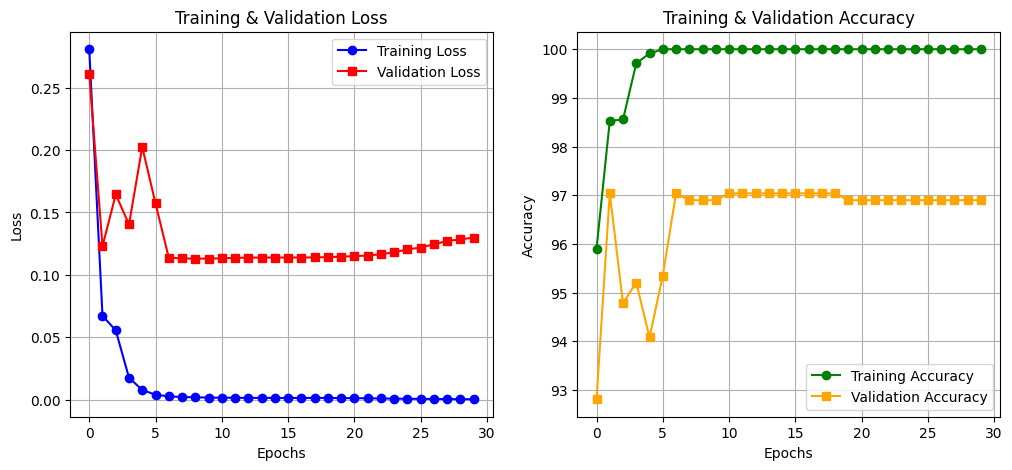

In [24]:
plotting(history4)


Evaluating model with Validation loader.

Overall Accuracy: 96.90%
Overall Error Rate: 3.10%
F1-Score (Macro-Averaged): 97.00%
F1-Score (Weighted): 96.90%
Matthews Correlation Coefficient (MCC): 96.38%
Cohen’s Kappa Score: 96.37%
Top-1 Accuracy (%): 96.90%
Top-5 Accuracy (%): 99.86%

Average Inference Time per Image: 0.033673 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          93.81       95.50         94.64            98.83
 BRRI_28          98.85       95.56         97.18            99.84
 BRRI_29          93.75       94.59         94.17            98.83
 BRRI_34          98.10       96.26         97.17            99.67
 BRRI_50          97.62      100.00         98.80            99.68
 BRRI_74          99.07      100.00         99.53            99.83
    BR_5          98.00       97.03         97.51            99.67

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                111
 BRRI

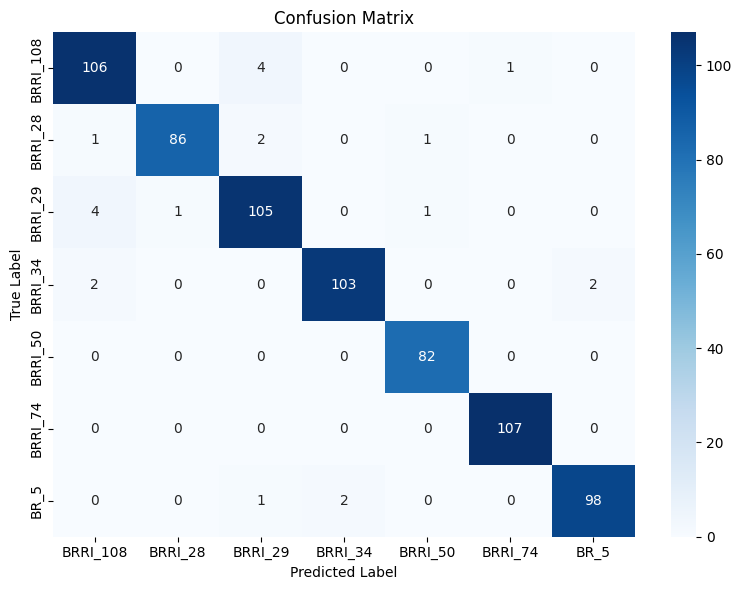

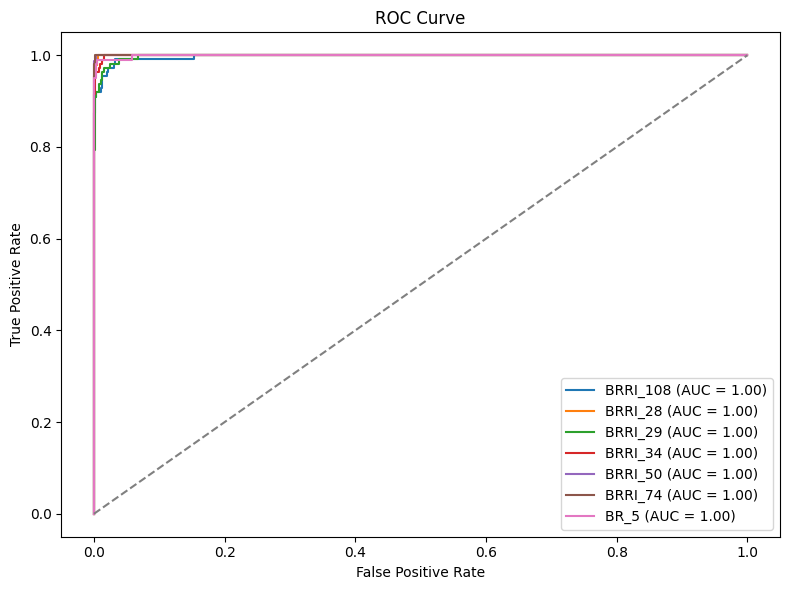

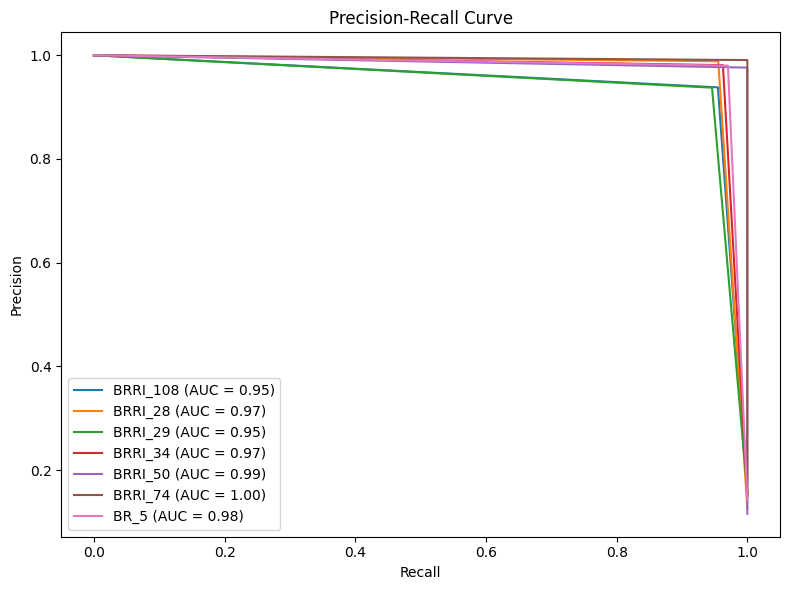

{'accuracy': 96.9,
 'error_rate': 3.1,
 'f1_macro': 97.0,
 'f1_weighted': 96.9,
 'roc_auc': 99.91,
 'mcc': 96.38,
 'kappa': 96.37,
 'top_k_accuracy': {'Top-1 Accuracy (%)': 96.89703808180536,
  'Top-5 Accuracy (%)': 99.8589562764457},
 'avg_inference_time': 0.03367256983715321,
 'class_metrics': [{'Class': 'BRRI_108',
   'Precision (%)': 93.81,
   'Recall (%)': 95.5,
   'F1-Score (%)': 94.64,
   'Specificity (%)': 98.83},
  {'Class': 'BRRI_28',
   'Precision (%)': 98.85,
   'Recall (%)': 95.56,
   'F1-Score (%)': 97.18,
   'Specificity (%)': 99.84},
  {'Class': 'BRRI_29',
   'Precision (%)': 93.75,
   'Recall (%)': 94.59,
   'F1-Score (%)': 94.17,
   'Specificity (%)': 98.83},
  {'Class': 'BRRI_34',
   'Precision (%)': 98.1,
   'Recall (%)': 96.26,
   'F1-Score (%)': 97.17,
   'Specificity (%)': 99.67},
  {'Class': 'BRRI_50',
   'Precision (%)': 97.62,
   'Recall (%)': 100.0,
   'F1-Score (%)': 98.8,
   'Specificity (%)': 99.68},
  {'Class': 'BRRI_74',
   'Precision (%)': 99.07,
   'Re

In [25]:
evaluate_model(model3, val_loader, class_names=dataset.classes, loader_name="Validation")


Evaluating model with Testing loader.

Overall Accuracy: 96.57%
Overall Error Rate: 3.43%
F1-Score (Macro-Averaged): 96.59%
F1-Score (Weighted): 96.56%
Matthews Correlation Coefficient (MCC): 96.00%
Cohen’s Kappa Score: 95.99%
Top-1 Accuracy (%): 96.57%
Top-5 Accuracy (%): 100.00%

Average Inference Time per Image: 0.033618 seconds

Class-Wise Performance Metrics:
   Class  Precision (%)  Recall (%)  F1-Score (%)  Specificity (%)
BRRI_108          95.50       90.60         92.98            99.18
 BRRI_28          97.50       97.50         97.50            99.51
 BRRI_29          91.58       94.57         93.05            98.74
 BRRI_34          96.43       99.08         97.74            99.35
 BRRI_50          97.27       99.07         98.17            99.52
 BRRI_74          97.83       98.90         98.36            99.69
    BR_5         100.00       96.74         98.34           100.00

Class-Wise Sample Distribution:
   Class  Support (Samples)
BRRI_108                117
 BRRI_2

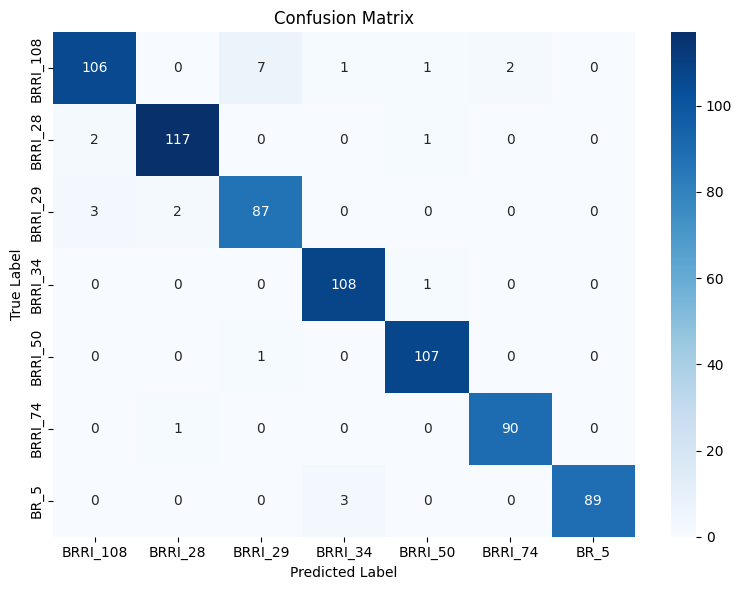

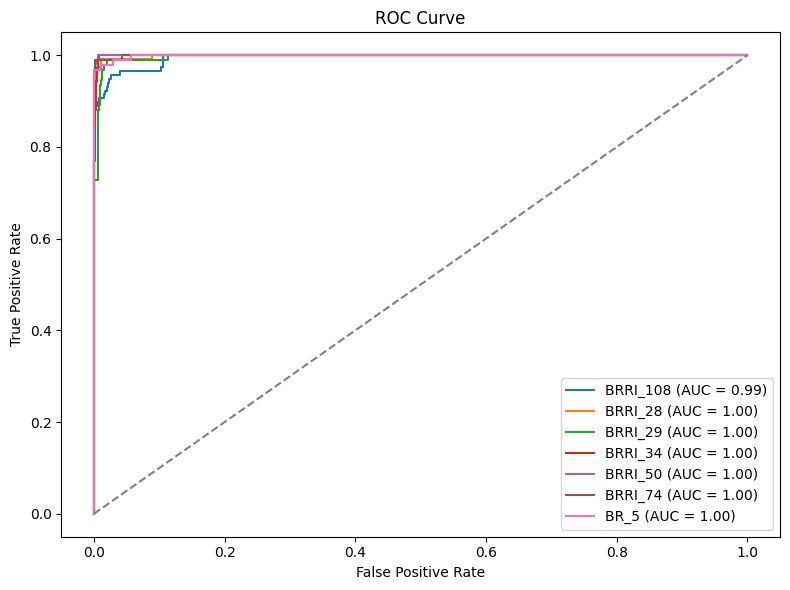

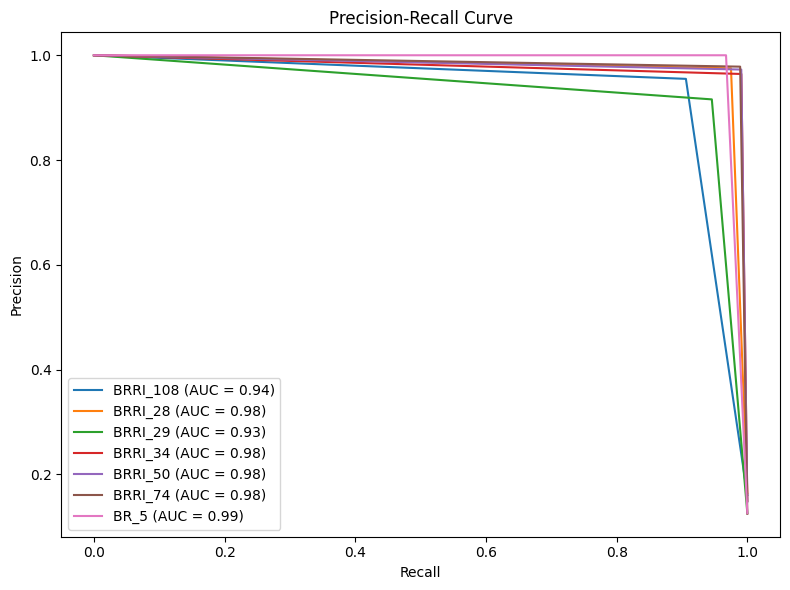

{'accuracy': 96.57,
 'error_rate': 3.43,
 'f1_macro': 96.59,
 'f1_weighted': 96.56,
 'roc_auc': 99.83,
 'mcc': 96.0,
 'kappa': 95.99,
 'top_k_accuracy': {'Top-1 Accuracy (%)': 96.57064471879286,
  'Top-5 Accuracy (%)': 100.0},
 'avg_inference_time': 0.03361823038799772,
 'class_metrics': [{'Class': 'BRRI_108',
   'Precision (%)': 95.5,
   'Recall (%)': 90.6,
   'F1-Score (%)': 92.98,
   'Specificity (%)': 99.18},
  {'Class': 'BRRI_28',
   'Precision (%)': 97.5,
   'Recall (%)': 97.5,
   'F1-Score (%)': 97.5,
   'Specificity (%)': 99.51},
  {'Class': 'BRRI_29',
   'Precision (%)': 91.58,
   'Recall (%)': 94.57,
   'F1-Score (%)': 93.05,
   'Specificity (%)': 98.74},
  {'Class': 'BRRI_34',
   'Precision (%)': 96.43,
   'Recall (%)': 99.08,
   'F1-Score (%)': 97.74,
   'Specificity (%)': 99.35},
  {'Class': 'BRRI_50',
   'Precision (%)': 97.27,
   'Recall (%)': 99.07,
   'F1-Score (%)': 98.17,
   'Specificity (%)': 99.52},
  {'Class': 'BRRI_74',
   'Precision (%)': 97.83,
   'Recall (%)':

In [26]:
evaluate_model(model3, test_loader, class_names=dataset.classes, loader_name="Testing")

History loaded for version 1


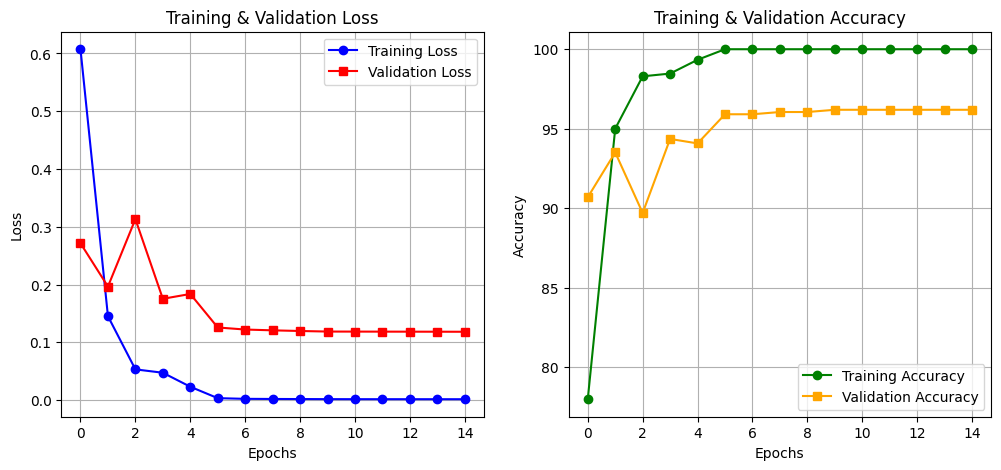

In [28]:
import os
import json

def load_history(version="V1", base_dir="/Users/tahfimibnkhan/Desktop/ViT_Final"):
    """
    Loads the full training history from a JSON file.

    Args:
        version (str): Version label used in the filename.
        base_dir (str): Root directory where history was saved.

    Returns:
        dict: Loaded history dictionary.
    """
    file_path = os.path.join(base_dir, "RESULTS", "logs", f"deit_small_full_history_{version}.json")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No history found for version {version} at {file_path}")

    with open(file_path, "r") as f:
        history = json.load(f)

    print(f"History loaded for version {version}")
    return history
history1 = load_history(version="1")
plotting(history1)

Merged 60 epochs of training.


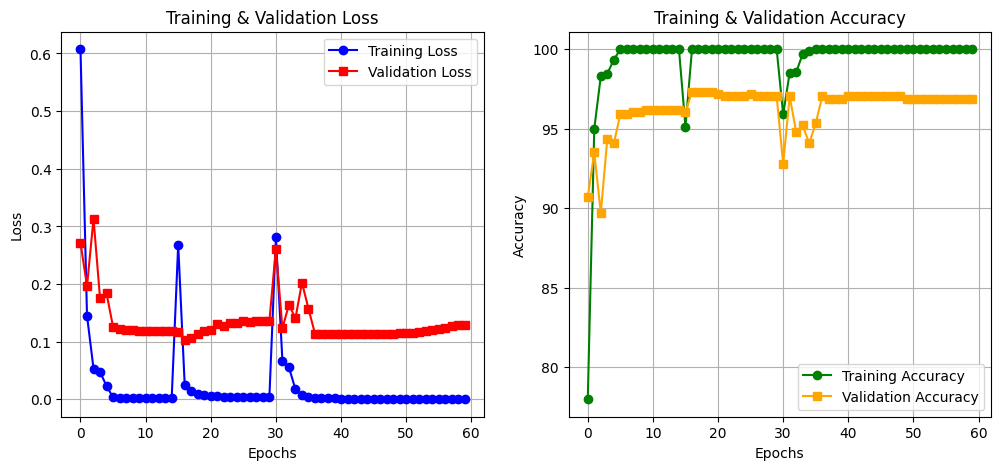

In [30]:
def merge_histories_and_plot(history1, history2, history3):
    """
    Merges three training history dictionaries and plots the combined training and validation curves.

    Args:
        history1, history2, history3: Dictionaries with keys "train_loss", "train_acc", "val_loss", "val_acc"
    """
    merged_history = {
        "train_loss": history1["train_loss"] + history2["train_loss"] + history3["train_loss"],
        "train_acc": history1["train_acc"] + history2["train_acc"] + history3["train_acc"],
        "val_loss": history1["val_loss"] + history2["val_loss"] + history3["val_loss"],
        "val_acc": history1["val_acc"] + history2["val_acc"] + history3["val_acc"]
    }

    print(f"Merged {len(history1['train_loss']) + len(history2['train_loss']) + len(history3['train_loss'])} epochs of training.")
    plotting(merged_history)
    return merged_history

final_history = merge_histories_and_plot(history1, history3, history4)